## Analysis of cardinality estimation pretraining results

In [79]:
from main import ROOT_DIR
import numpy as np
import pickle
import os
import matplotlib
from ipywidgets import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style



In [80]:
def read_pretrain_results(location):
    with open(os.path.join(ROOT_DIR, location), 'rb') as f:
        read_data = pickle.load(f)
        return read_data

def read_all_ckp(location_template, n_ckp):
    all_stats = []
    for i in range(n_ckp):
        all_stats.append(read_pretrain_results(location_template.format(i)))
    return all_stats

ckp_location_template = "data/output/cardinality_estimation/cardinality_estimation_20k/ckp_{}/statistics"
data = read_all_ckp(ckp_location_template, 10)

In [81]:
def read_checkpoint_data(ckp_data, key_name, epoch):
    epoch_data = ckp_data[epoch]
    relevant_data = epoch_data[key_name]
    
    pred = []
    actual = []
    loss = []
    q_error = []
    for value in relevant_data.values():
        pred.append(value['prediction'])
        actual.append(value['actual'])
        loss.append(value['loss'])
        q_error.append(value['q_error'])
    return pred, actual, loss, q_error

def prepare_slider_histogram_plot(data, key_name, n_epoch):
    slider_data_pred = []
    slider_data_actual = []
    slider_data_loss = []
    slider_data_q_error = []

    for i in range(n_epoch):
        pred, actual, loss, q_error = read_checkpoint_data(data, key_name, i)
        slider_data_pred.append(pred)
        slider_data_actual.append(actual)
        slider_data_loss.append(loss)
        slider_data_q_error.append(q_error)
    
    return slider_data_pred, slider_data_actual, slider_data_loss, slider_data_q_error

train_pred, train_actual, train_loss, train_q_error = prepare_slider_histogram_plot(data, 'train_stats', 10)
val_pred, val_actual, val_loss, val_q_error = prepare_slider_histogram_plot(data, 'val_stats', 10)
test_pred, test_actual, test_loss, test_q_error = prepare_slider_histogram_plot(data, 'test_stats', 10)

In [82]:
%matplotlib widget

def create_histogram(histogram_data, n_bins, label, total_min, total_max, add_line, index_to_average):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    
    histogram_list = [histogram_data[i] for i in range(histogram_data.shape[0])]
    y, x, _ = ax.hist(histogram_list, bins=n_bins, label=label, alpha=.5)
    ax.legend()
    if add_line:
        ax.vlines(np.mean(histogram_data[index_to_average]), 0, np.max(y), linestyles='dashed',colors='r')
    return fig, ax
    

def update(histogram_data, 
           n_bins, 
           label,
           ax, fig,
           min_val, max_val,
           add_line,
           index_to_average,
           epoch = widgets.IntSlider(min=0, max=9, step=1, value=0)):
    epoch_data = histogram_data[:,epoch,:]
    epoch_min = np.min(epoch_data.flatten())
    epoch_max = np.max(epoch_data.flatten())
    
    min_diff = min_val - epoch_min
    max_diff = max_val - epoch_max
    range_diff = np.min([min_diff, max_diff])
    
    ax.clear()
    
    histogram_list = [epoch_data[i] for i in range(histogram_data.shape[0])]

    y, x, _ = ax.hist(histogram_list, label=label, bins=n_bins, alpha=.5)
        
    if add_line:
        ax.vlines(np.mean(epoch_data[index_to_average]), 0, np.max(y), linestyles='dashed',colors='r')
    
    ax.legend()
    fig.canvas.draw_idle()

def create_interactive_plot(n_bins, histogram_data, label, add_line=True, index_to_average=0):
    # Histogram data in format: [different histograms][epochs][datapoints]
    plt.close('all')
    all_data = np.array(histogram_data).flatten()
    total_min = np.min(all_data)
    total_max = np.max(all_data)
    
    fig, ax = create_histogram(histogram_array[:,0,:], n_bins, label, total_min=total_min, total_max=total_max, 
                               add_line=add_line, index_to_average=index_to_average)
    interact(update, 
             histogram_data = fixed(histogram_array), 
             n_bins = fixed(n_bins),
             label = fixed(label),
             ax = fixed(ax),
             fig = fixed(fig),
             add_line = fixed(add_line),
             index_to_average = fixed(index_to_average),
             min_val = fixed(total_min), max_val = fixed(total_max)
            )

#TODO Plot interactive plot pred-card
#TODO Plot interactive plot q-error

interactive(children=(IntSlider(value=9, description='epoch', max=9), Output()), _dom_classes=('widget-interac…

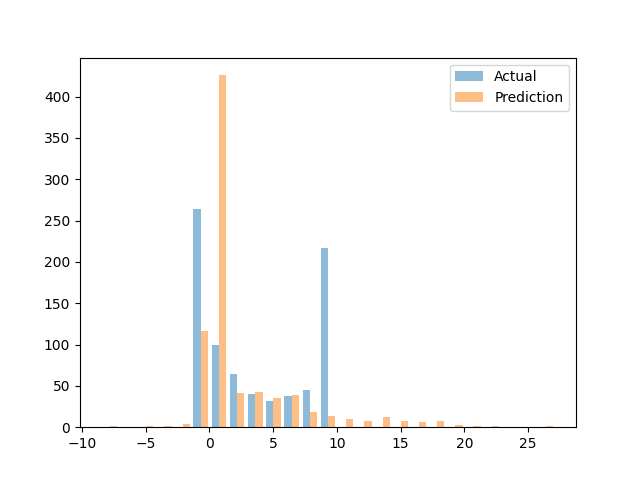

In [65]:
# rescaled_train_actual = np.exp(np.array(train_actual)) - 1
# rescaled_train_pred = np.exp(np.array(train_pred)) - 1

create_interactive_plot(25, np.array([train_actual, train_pred]), ["Actual", "Prediction"], add_line=False, index_to_average=1)

interactive(children=(IntSlider(value=9, description='epoch', max=9), Output()), _dom_classes=('widget-interac…

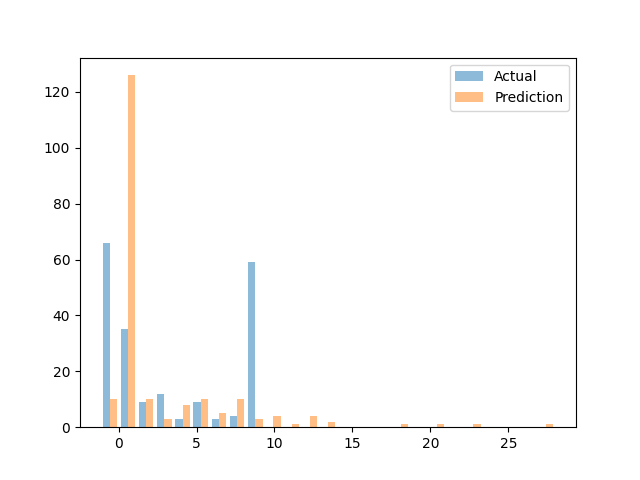

In [56]:
create_interactive_plot(25, [val_actual, val_pred], ["Actual", "Prediction"], add_line=False, index_to_average=1)

In [84]:
def process_epoch_line_plot_data(data):
    mean_per_epoch = [np.mean(data_epoch) for data_epoch in data]
    std_per_epoch = [np.std(data_epoch) for data_epoch in data]
    min_per_epoch = [np.min(data_epoch) for data_epoch in data]
    max_per_epoch = [np.max(data_epoch) for data_epoch in data]
    sample_size = len(data[0])
    return mean_per_epoch, std_per_epoch, min_per_epoch, max_per_epoch, sample_size

m_train_loss, std_train_loss, _, _, sample_size_train = process_epoch_line_plot_data(train_loss)
m_train_q_error, std_train_q_error, _, _, sample_size_train_2 = process_epoch_line_plot_data(train_q_error)
m_val_loss, std_val_loss, _, _, sample_size_val = process_epoch_line_plot_data(val_loss)
m_val_q_error, std_val_q_error, _, _, sample_size_val_2 = process_epoch_line_plot_data(val_q_error)

800
200


In [92]:
matplotlib.style.use('classic')
"""
Plot accepts an array of means and standard deviations to plot, given they all have the same sample size
"""
def plot_line_plot_with_ci(mean_data, std_data, legend, line_color, fill_color, sample_size, title, x_label, y_label):
    # Custom color palette
    # line_color = '#1f77b4'
    # fill_color = '#aec7e8'
        
    x = np.arange(0, len(mean_data[0]))
    for i in range(len(mean_data)):
        plt.plot(x, mean_data[i], label=legend[i], color=line_color[i])
        plt.fill_between(x, 
                         mean_data[i] - 1.96 * (std_data[i] / np.sqrt(sample_size[i])), 
                         mean_data[i] + 1.96 * (std_data[i] / np.sqrt(sample_size[i])),
                         alpha=.25,
                         color=fill_color[i],
                        )
    
    plt.title(title, fontsize=16)
    plt.xlabel(x_label, fontsize=14)
    plt.ylabel(y_label, fontsize=14)
    plt.legend(loc='best', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()

    plt.show()

plt.close('all')

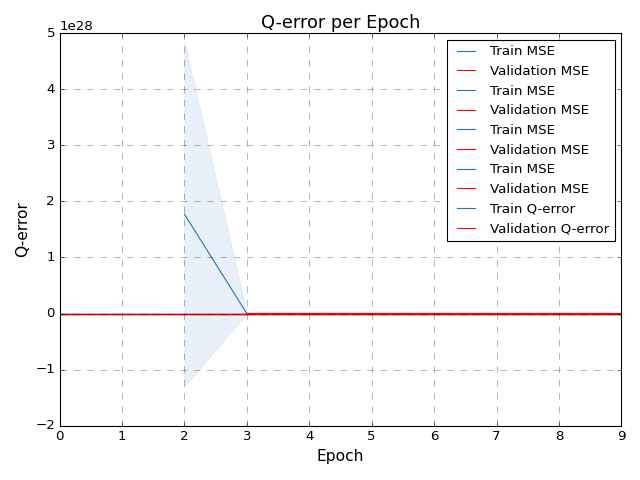

In [89]:
plot_line_plot_with_ci([m_train_y, m_val_y], [std_train_loss, std_val_loss], 
                       ["Train MSE", "Validation MSE"], 
                       ['#1f77b4', "Red"], ['#aec7e8', "lightcoralr"],
                       [sample_size_train, sample_size_val], 
                       "Validation Loss per Epoch", "Epoch", "Mean Absolute Error"
                      )


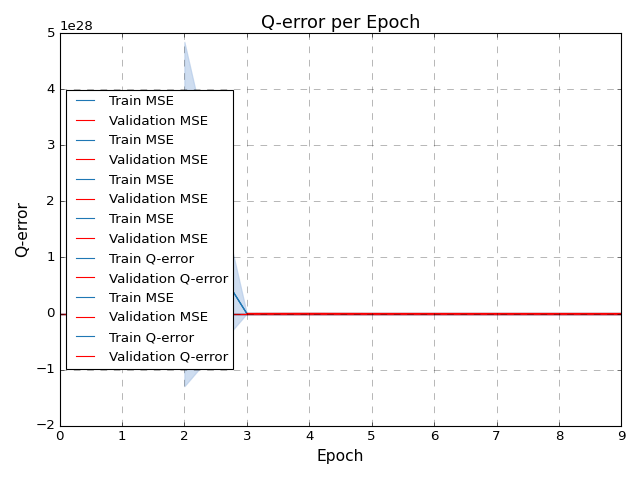

In [91]:
plot_line_plot_with_ci([m_train_q_error, m_val_q_error], [std_train_q_error, std_val_q_error], 
                       ["Train Q-error", "Validation Q-error"], 
                       ['#1f77b4', "Red"], ['#aec7e8', "lightcoral"],
                       [sample_size_train, sample_size_val], 
                       "Q-error per Epoch", "Epoch", "Q-error"
                      )


In [ ]:
#TODO: Create Q-error voilin plot!
